In [1]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from fastkde import fastkde
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('data/train.csv')

subset_size = int(len(train_data) / 10)
# subset the df to contain 10% of the data
train_data = train_data.sample(n=subset_size)

# split data into features and target
y = train_data['target']
x = train_data.drop(columns=['target','id'])

In [3]:
# run k-fold cross-validation
def cross_validate(kf,x,y,model):
    list_cm = []
    accuracy = []
    recall = []
    for train_index, test_index in kf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        recall.append(recall_score(y_test,y_pred, average='binary'))
        list_cm.append(confusion_matrix(y_test,y_pred))
    # we return our confusion matrices, accuraciy values, and recall values for output
    return list_cm, accuracy, recall

Original Class Counts:
Class 0: 57337
Class 1: 2184

Proportion: 26.25 : 1


<Axes: title={'center': 'Counts for each class'}, xlabel='Class', ylabel='Count'>

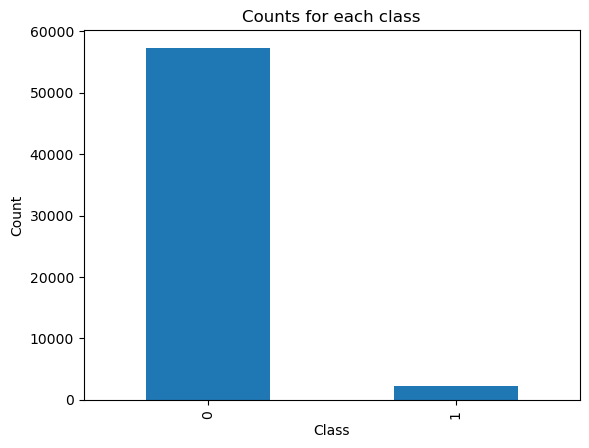

In [4]:
target_counts = y.value_counts()
print('Original Class Counts:')
print('Class 0:', target_counts[0])
print('Class 1:', target_counts[1])
print()
print('Proportion:', round(target_counts[0] / target_counts[1], 2), ': 1')

# plot the initial distribution of classes
target_counts.plot(kind='bar', title='Counts for each class', xlabel='Class', ylabel='Count')

### Synthetic Minority Oversampling (SMOTE)

In [5]:
oversample = SMOTE() # we use SMOTE to create an artificial oversample of the minority class
Xs, ys = oversample.fit_resample(x, y)
counter = Counter(ys)

In [6]:
model = KNeighborsClassifier() # we use k nearest neighbors to create clusters
SKFold = StratifiedKFold(n_splits=5)
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)
list_cm, accuracy, recall = cross_validate(SKFold, Xs_scaled, ys, model) #assign cm, accuracy, recall scores to the model

SMOTE Class Counts:
Class 0: 57337
Class 1: 57337

Proportion: 1.0 : 1


<Axes: title={'center': 'Class Counts Using SMOTE'}, xlabel='Class', ylabel='Count'>

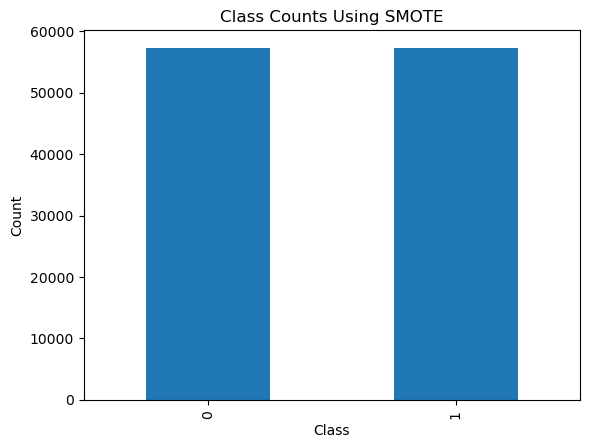

In [7]:
smote_counts = ys.value_counts()
print('SMOTE Class Counts:')
print('Class 0:', smote_counts[0])
print('Class 1:', smote_counts[1])
print()
print('Proportion:', round(smote_counts[0] / smote_counts[1], 3), ': 1')

# plot oversampled data
smote_counts.plot(kind='bar', title='Class Counts Using SMOTE', xlabel='Class', ylabel='Count')

In [8]:
# now we print the results
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall: {np.mean(recall)}")
print(f"Confusion Matrix Average:\n {np.mean(list_cm, axis=0)}")

Accuracy: 0.8869229245221912
Recall: 0.999337228568937
Confusion Matrix Average:
 [[8.88160e+03 2.58580e+03]
 [7.60000e+00 1.14598e+04]]


In [9]:
# results by fold
print(f"Fold 1 Confusion Matrix:\n {list_cm[0]}")
print(f"Fold 1 Accuracy: {accuracy[0]}")
print(f"Fold 1 Recall: {recall[0]}")
print()
print(f"Fold 2 Confusion Matrix:\n {list_cm[1]}")
print(f"Fold 2 Accuracy: {accuracy[1]}")
print(f"Fold 2 Recall: {recall[1]}")
print()
print(f"Fold 3 Confusion Matrix:\n {list_cm[2]}")
print(f"Fold 3 Accuracy: {accuracy[2]}")
print(f"Fold 3 Recall: {recall[2]}")
print()
print(f"Fold 4 Confusion Matrix:\n {list_cm[3]}")
print(f"Fold 4 Accuracy: {accuracy[3]}")
print(f"Fold 4 Recall: {recall[3]}")
print()
print(f"Fold 5 Confusion Matrix:\n {list_cm[4]}")
print(f"Fold 5 Accuracy: {accuracy[4]}")
print(f"Fold 5 Recall: {recall[4]}")

Fold 1 Confusion Matrix:
 [[ 8848  2620]
 [   38 11429]]
Fold 1 Accuracy: 0.884107259646828
Fold 1 Recall: 0.9966861428446847

Fold 2 Confusion Matrix:
 [[ 8908  2560]
 [    0 11467]]
Fold 2 Accuracy: 0.8883802049269676
Fold 2 Recall: 1.0

Fold 3 Confusion Matrix:
 [[ 8880  2587]
 [    0 11468]]
Fold 3 Accuracy: 0.8872029649008066
Fold 3 Recall: 1.0

Fold 4 Confusion Matrix:
 [[ 8911  2556]
 [    0 11468]]
Fold 4 Accuracy: 0.8885546108567691
Fold 4 Recall: 1.0

Fold 5 Confusion Matrix:
 [[ 8861  2606]
 [    0 11467]]
Fold 5 Accuracy: 0.8863695822795848
Fold 5 Recall: 1.0


### ADASYN with FastKDE

In [10]:
x_arr = np.array(x)
y_arr = np.array(y)

kde_points = 257 # 57 features, so we choose 257 as our number of points
var_names_ = [f'feature_{i}' for i in range(x_arr.shape[1])]

In [11]:
# we want to get the density estimation for each feature
kde_PDF_dict = {}
# we store the results in a dictionary
for i in range(x_arr.shape[1]):
    kde_PDF_dict[f'feature_{i}'] = fastkde.pdf(x_arr[:, i], var_names=[var_names_[i]], num_points=kde_points)

In [12]:
model = KNeighborsClassifier()
SKFold = StratifiedKFold()
# use adasyn to resample the minority class
adasyn = ADASYN(sampling_strategy='minority',n_neighbors=5)
x_resampled, y_resampled = adasyn.fit_resample(x_arr,y_arr)

Original Class Counts:
Class 0: 57337
Class 1: 56748

Proportion: 1.01 : 1


<Axes: title={'center': 'Counts for each class'}, xlabel='Class', ylabel='Count'>

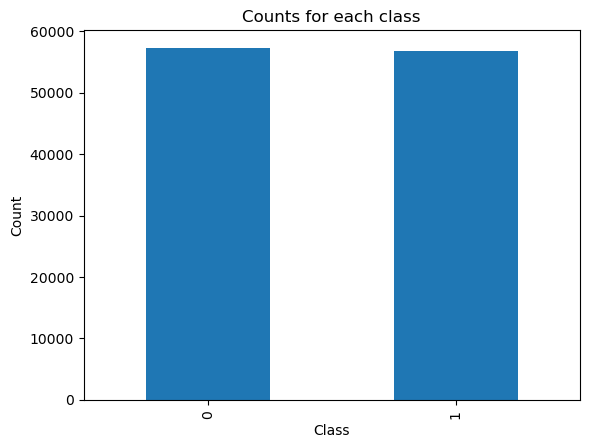

In [21]:
# we have to convert back to df so we can visualize the class counts
y_series = pd.Series(y_resampled, name='class')
target_counts = y_series.value_counts()
print('Original Class Counts:')
print('Class 0:', target_counts[0])
print('Class 1:', target_counts[1])
print()
print('Proportion:', round(target_counts[0] / target_counts[1], 2), ': 1')

# plot the initial distribution of classes
target_counts.plot(kind='bar', title='Counts for each class', xlabel='Class', ylabel='Count')

In [13]:
# now we want to return our confusion matrices, accuracy, and recall for classification 
# after resampling with ADASYN & cross-validating with SKFold, using KNN as our model for classification
cm_list, accuracy, recall = cross_validate(SKFold, x_resampled, y_resampled, model)

In [14]:
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall: {np.mean(recall)}")
print(f"Confusion Matrix Average:\n {np.mean(cm_list, axis=0)}")

Accuracy: 0.8093877372134811
Recall: 0.973408805060742
Confusion Matrix Average:
 [[ 7420.   4047.4]
 [  301.8 11047.8]]


In [15]:
# results by fold
print(f"Fold 1 Confusion Matrix:\n {cm_list[0]}")
print(f"Fold 1 Accuracy: {accuracy[0]}")
print(f"Fold 1 Recall: {recall[0]}")
print()
print(f"Fold 2 Confusion Matrix:\n {cm_list[1]}")
print(f"Fold 2 Accuracy: {accuracy[1]}")
print(f"Fold 2 Recall: {recall[1]}")
print()
print(f"Fold 3 Confusion Matrix:\n {cm_list[2]}")
print(f"Fold 3 Accuracy: {accuracy[2]}")
print(f"Fold 3 Recall: {recall[2]}")
print()
print(f"Fold 4 Confusion Matrix:\n {cm_list[3]}")
print(f"Fold 4 Accuracy: {accuracy[3]}")
print(f"Fold 4 Recall: {recall[3]}")
print()
print(f"Fold 5 Confusion Matrix:\n {cm_list[4]}")
print(f"Fold 5 Accuracy: {accuracy[4]}")
print(f"Fold 5 Recall: {recall[4]}")
# Here we see that ADASYN performs worse than SMOTE, though perhaps using a model besides KNN could yield better results

Fold 1 Confusion Matrix:
 [[ 7287  4181]
 [  230 11119]]
Fold 1 Accuracy: 0.8066792303983872
Fold 1 Recall: 0.9797338972596704

Fold 2 Confusion Matrix:
 [[ 7498  3970]
 [  341 11008]]
Fold 2 Accuracy: 0.8110619275101898
Fold 2 Recall: 0.9699532998502071

Fold 3 Confusion Matrix:
 [[ 7331  4136]
 [  418 10932]]
Fold 3 Accuracy: 0.8004119735285095
Fold 3 Recall: 0.9631718061674008

Fold 4 Confusion Matrix:
 [[ 7475  3992]
 [  248 11102]]
Fold 4 Accuracy: 0.8141736424595696
Fold 4 Recall: 0.9781497797356828

Fold 5 Confusion Matrix:
 [[ 7509  3958]
 [  272 11078]]
Fold 5 Accuracy: 0.8146119121707499
Fold 5 Recall: 0.9760352422907489


### Normalizing Flows

In [27]:
data = pd.read_csv('data/train.csv')

X = data.drop(columns=['target','id']).values
y = data['target'].values